# Short-Story Generator_v2

[WIP]
Strategy: using a pre-trained model and fine-tuning it with our scenario-specific dataset. 
Why: pre-trained model has already trained the vocab and position embedding matrix for general English language (the model already learned the grammar, sentence structure, language rules....), we do not need to retrain this (would be computationally expensive), additionally we can keep the model weights learned of this model. 

## 1. Loading all libraries


In [1]:
# Install required libraries

!pip install torch==1.6.0 torchvision==0.7.0 #downgrading to Pytorch 1.6 to prevent error, https://forums.fast.ai/t/attributeerror-fakeloader-object-has-no-attribute-persistent-workers/81167/5

!pip install fastai==2.0.15
!pip install fastai2==0.0.30
!pip install fastcore==1.0.16

!pip install -Uqq fastbook

!pip install tokenizers
!pip install transformers #!pip install -Uq transformers

  Using cached https://files.pythonhosted.org/packages/5d/5e/35140615fc1f925023f489e71086a9ecc188053d263d3594237281284d82/torch-1.6.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/4d/b5/60d5eb61f1880707a5749fea43e0ec76f27dfe69391cdec953ab5da5e676/torchvision-0.7.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: fastai 2.3.0 has requirement torch<1.8,>=1.7.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: fastai 2.3.0 has requirement torchvision<0.9,>=0.8, but you'll have torchvision 0.7.0 which is incompatible.
  Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2
  Using cached https://files.pythonhosted.org/packages/98/2e/d4dcc69f67b4557c8543a4c

In [2]:
# Import required libraries
import pandas as pd

from fastai.text.all import *

import fastbook
from fastbook import *
fastbook.setup_book()

from IPython.display import display,HTML

In [3]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

Let's load our English GPT-2 pretrained model. Given the size of the model and our requirements to produce simple, child-like language, we will load only the small GPT-2 model with 768MM parameters (vs. medium with 1024MM parameters and large with 1280MM parameters). The extra large model with 1600MM was never released due to potentially harmful uses. 

The full configuration of the GPT-2 small can be found here: https://huggingface.co/transformers/model_doc/gpt2.html#transformers.GPT2Config

We load a specific class of the GPT2 model, the GPT2LMHeadModel: it is a GPT2 Model transformer with a language modeling head on top (linear layer with weights tied to the input embeddings). It inherits its configuration from pretrainedModel; this is also where we load the weights from.

In [4]:
# Load pre-trained model (weights)
pretrained_weights = 'gpt2'

tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)

model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

When using a pretrained model, it is important to use the associated pretrained tokenizer with it to ensure that it will split the text for the fine-tuning in the exact same way as the pretraining corpus and it will use the same correspondance token to index (vocab) as during pretraining. The GPT-2 tokenizer is based on Byte-Pair-Encodings. It detects the beinning of a word by the preceding space and has been trained to treat spaces like parts of the tokens (a bit like sentencepiece) so a word will be encoded differently whether it is at the beginning of the sentence (without space) or not. [Source](https://huggingface.co/transformers/model_doc/gpt2.html#transformers.GPT2Config)
The English pre-trained GPT-2 tokenizer consists of a vocab of 50.257 tokens.

## 2. Loading Preprocessing Text

In [5]:
# Import the data
gist = "https://gist.githubusercontent.com/frau-web/84b7a2155e97d479db0ca91b6fc3a0db/raw/89460c734dd7ba87ae6e6b4c4ffaebfa2f8f2f81/shortstories.txt"
df = pd.read_csv(gist, sep='\t', header=None) 


In [6]:
# Split into test and train
from sklearn.model_selection import train_test_split

train_test_ratio = 0.9
#train_valid_ratio = 7/9
df_full_train, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1)
#df_train, df_valid = train_test_split(df_full_train, train_size = train_valid_ratio, random_state = 1)



We will now build a Transform that will be applied lazily, using the **fastAI Tokenizer**. In a  fastai transform we can define (among others): 
- an **encodes method**: applied when calling the transform (think: forward method in a neural net module)
- a **decodes method**: applied when calling the decode method of the transform, e.g. if anything needs to be decoded for showing purposes (converting ids to a text)
[Source](https://medium.com/@pierre_guillou/faster-than-training-from-scratch-fine-tuning-the-english-gpt-2-in-any-language-with-hugging-f2ec05c98787)

In [7]:
# To process this data to train a model, we need to build a Transform that will be applied lazily.

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))



Two comments on the code above:
- in encodes we don't use the tokenizer.encode method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in decodes we return a TitledStr object and not just a plain string. That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.



Next, we are **creating our Dataset and Dataloader** using Transform and a TfmdList. 
Tfmd List contains the training and validation dataset, which we create with 'splits'. 
Since we are dealing with a Language Model, we specify dl_type= LMDataLoader when converting the TfmdLists (containing our train and validation data) to DataLoaders. 
The Fastai library expects its input as a DataLoader object, containing train and validation set.

In [8]:
# We gather all texts in one numpy array (since it will be easier to use this way with fastai)
all_texts = np.concatenate([df_full_train[0].values, df_test[0].values])

# We define the split between training and validation data
splits = [range_of(df_full_train), list(range(len(df_full_train), len(all_texts)))]

# We create the tls [WIP - EXPLAIN WHAT TLS IS]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [9]:
tls.train[0],tls.valid[0]

(tensor([1026,  373,  355, 4692,  379, 1363,  355,  287,  262, 4675,   13, 1119,  547, 1165, 3595,  284,  423]),
 tensor([  464,  6175,  2227,   284,   307,   588,   262, 11858,    13,  1406,   339,   531,   284, 31771,    11,   366,    40,   481]))

In [10]:
show_at(tls.train, 0)

It was as cold at home as in the street. They were too poor to have


[tbd if rewrite]: The fastai library expects the data to be assembled in a DataLoaders object (something that has a training and validation dataloader). We can get one by using the dataloaders method. We just have to specify a batch size and a sequence length. We'll train with sequences of size 256 (GPT2 used sequence length 1024, but not everyone has enough GPU RAM for that):
[Comment from Portuguese:]  
- Let’s use a batch size of 8 (a value higher gives a “CUDA out of memory error” on our single GPU).
- Since the GPT-2 model was trained with sequences of size 1024, we use this sequence length (it’s a stateless model, so it will change the perplexity if we use less).

In [11]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [12]:
dls.show_batch(max_n=2)

,text,text_
0,"tool-shed, perhaps hidden underneath a flower-pot. He began to turnAll the gods came around to see. Then Loki came up to show his things.So Brok blew as hard as he could.happened, he came out, and climbed upon a wheelbarrow and peeped over.step--pit pat, paddle pat! pit pat, waddle pat!Nutkin began again ""Arthur O'Bower has broken his band, he comes roaring up the land!When Sif woke up and saw that her hair was gone, she cried andwill fly up to Thor's house and get the hammer.""The wolf ran off and took a short way, but Red Riding-Hood stopped toOn the third day the squirrels got up very early and went fishing; theyWhen Red Riding-Hood tapped on the door, the wolf called out, ""Who isanimals.He lost one of his shoes among the cabbages, and the other shoeThey cut at the Harpies but could not hurt them.to Owl Island to gather nuts.Just then","-shed, perhaps hidden underneath a flower-pot. He began to turnAll the gods came around to see. Then Loki came up to show his things.So Brok blew as hard as he could.happened, he came out, and climbed upon a wheelbarrow and peeped over.step--pit pat, paddle pat! pit pat, waddle pat!Nutkin began again ""Arthur O'Bower has broken his band, he comes roaring up the land!When Sif woke up and saw that her hair was gone, she cried andwill fly up to Thor's house and get the hammer.""The wolf ran off and took a short way, but Red Riding-Hood stopped toOn the third day the squirrels got up very early and went fishing; theyWhen Red Riding-Hood tapped on the door, the wolf called out, ""Who isanimals.He lost one of his shoes among the cabbages, and the other shoeThey cut at the Harpies but could not hurt them.to Owl Island to gather nuts.Just then"
1,",Peter scuttered underneath the bushes. But presently, as nothingThen the same fly came in and bit him again.kill Jason.down like a little red cherry, singing ""Riddle me, riddle me, rot-tot-tote! He said to Brok, ""Now blow as hard as you can.""How big your ears are, grandma.Her feet were bare. When she left home, she had on some big slippersThen Loki said, ""I can't stand this. I will get the apples for you.""Then Sindre put a lump of iron into the fire.Peter gave himself up for lost, and shed big tears; but his sobs wereGretchen got colder and colder.a Christmas tree. Very many candles were on the tree. It was fulltied was not far off.duckling.There on the grass was a fine large sheep. This sheep had a fleece ofAnd Sindre went out. Brok blew and blew. The same mean fly came again,By and by he grew tame and let the children","Peter scuttered underneath the bushes. But presently, as nothingThen the same fly came in and bit him again.kill Jason.down like a little red cherry, singing ""Riddle me, riddle me, rot-tot-tote! He said to Brok, ""Now blow as hard as you can.""How big your ears are, grandma.Her feet were bare. When she left home, she had on some big slippersThen Loki said, ""I can't stand this. I will get the apples for you.""Then Sindre put a lump of iron into the fire.Peter gave himself up for lost, and shed big tears; but his sobs wereGretchen got colder and colder.a Christmas tree. Very many candles were on the tree. It was fulltied was not far off.duckling.There on the grass was a fine large sheep. This sheep had a fleece ofAnd Sindre went out. Brok blew and blew. The same mean fly came again,By and by he grew tame and let the children"


### - Alternative


Another way to gather the data is to preprocess the texts once and for all and only use the transform to decode the tensors to texts:

In [13]:
all_texts_copy = all_texts.copy()

In [14]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts_copy)]

In [15]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [16]:
tls_copy = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [17]:
dls.show_batch(max_n=2)

,text,text_
0,"blackberries for supper.Twinkleberry and six other little squirrels each carried a fat minnow; butHe saw Sif lying asleep. He said, ""I am going to cut off her hair.""The King of Scots with all his power, cannot turn Arthur of the Bower!""Mr. McGregor came up with a sieve, which he intended to pop upon theWhen it was noon the ground was all plowed.So Loki went up on the porch and cut off Sif's golden hair.Then Brok showed the hammer. He said, ""This is not a very prettyLoki said, ""You will have to, if we get the hammer back.""Gretchen thought she was sitting by a big stove. It was so bright.Still Freyja said, ""I will not go."" And she was very angry. She shookOne day they were playing in the garden.Jason pushed the bulls' heads down to the ground. Then they kicked atThis looks like the end of the story; but it","berries for supper.Twinkleberry and six other little squirrels each carried a fat minnow; butHe saw Sif lying asleep. He said, ""I am going to cut off her hair.""The King of Scots with all his power, cannot turn Arthur of the Bower!""Mr. McGregor came up with a sieve, which he intended to pop upon theWhen it was noon the ground was all plowed.So Loki went up on the porch and cut off Sif's golden hair.Then Brok showed the hammer. He said, ""This is not a very prettyLoki said, ""You will have to, if we get the hammer back.""Gretchen thought she was sitting by a big stove. It was so bright.Still Freyja said, ""I will not go."" And she was very angry. She shookOne day they were playing in the garden.Jason pushed the bulls' heads down to the ground. Then they kicked atThis looks like the end of the story; but it"
1,"cautiously, peeping round the tree--there was OldNow she thought she could look into a room. In this room was a table.In the evening he came back.They were as high as a big hill. They would come close to each other,He put his head down to the water. What did he see? He saw himself init at anything, it will hit the mark and come back to you.""They did not want Jason killed. They did not know that the princessThen she put a stick into the pot and leaves grew on it.But Peter, who was very naughty, ran straight away to Mr. McGregor'she could. He said, ""It is little Red Riding-Hood, grandma.""suit. He walked and walked until he came to Thrym's house. Thrym wasWhen Sif woke up and saw that her hair was gone, she cried andThe next day Jason had to plow with the brass bulls and plant theAnd",", peeping round the tree--there was OldNow she thought she could look into a room. In this room was a table.In the evening he came back.They were as high as a big hill. They would come close to each other,He put his head down to the water. What did he see? He saw himself init at anything, it will hit the mark and come back to you.""They did not want Jason killed. They did not know that the princessThen she put a stick into the pot and leaves grew on it.But Peter, who was very naughty, ran straight away to Mr. McGregor'she could. He said, ""It is little Red Riding-Hood, grandma.""suit. He walked and walked until he came to Thrym's house. Thrym wasWhen Sif woke up and saw that her hair was gone, she cried andThe next day Jason had to plow with the brass bulls and plant theAnd Thrym"


## 3. Training (Fine-tuning the model)

In [18]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

If we'd have GPU, we could make use of mixed precision by adding the fp16 flag (to save memory and speed up training time)

In [19]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[accuracy, Perplexity()]) #.to_fp16()

In [20]:
# Check how good the model is doing with out any fine-tuning step
learn.validate()

(#3) [4.654792308807373,0.2578125,105.08739471435547]

This lists the validation loss and metrics, perplexity of 105 is pretty bad :)

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.002511886414140463)

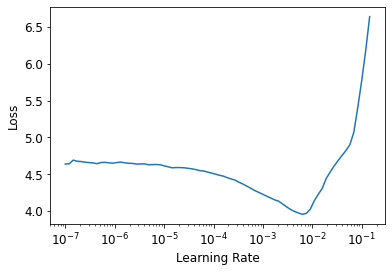

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.240373,3.819117,0.305779,45.563961,03:13
1,3.678046,3.701545,0.311121,40.509865,03:26
2,3.217972,3.740043,0.324621,42.099789,03:12


In [23]:
prompt = "\n = Dog = \n \n Once upon a time there was a magic dog."

If we'd have a GPU, we could put everything on cuda:
(1) tokens_tensor = tokens_tensor.to('cuda'); 
(2) model.to('cuda')

In [24]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None] #.cuda()
inp.shape

torch.Size([1, 18])

#### (a) Output: beams search

In [25]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [26]:
tokenizer.decode(preds[0].cpu().numpy())

'\n = Dog = \n \n Once upon a time there was a magic dog. It was named Red Riding-Hood. She was so glad to come. She said, "I will have a good time. I will dress like Freyja, and have a good time. I will dress like Freyja, and have a good time. I will dress like Freyja, and have a good time."Then Sindre went to the king and said, "Give me your head."'

#### (b) Ouutput: random sampling search

In [35]:
preds = learn.model.generate(inp, do_sample = True, max_length=100, top_k=50, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [36]:
tokenizer.decode(preds[0].cpu().numpy())

'\n = Dog = \n \n Once upon a time there was a magic dog.the gods knew what it mean to him in the name of "scientifically untied, scufflement from scufflement, scufflement from thein French and the evening, when the wolf got here very early...then sit down to the table to eat: Brok\'sThe mother duck said, \'Oh God, we are sobig. But she did not want herthree men on the'

#### (c) Unfreezing to further improve

In [29]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.533128,3.742643,0.314338,42.209415,03:12
1,2.344917,3.999513,0.298397,54.571548,03:20
2,2.064552,4.214323,0.305750,67.648354,03:12


In [30]:
preds = learn.model.generate(inp, do_sample = True, max_length=100, top_k=50, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [31]:
tokenizer.decode(preds[0].cpu().numpy())

'\n = Dog = \n \n Once upon a time there was a magic dog. AllThe king did not want Jason brought back. His wife would haveHe held the egg in his arms. At last he found a hollow apple.When Thor woke in the morning he went off to lookfor the eagle\'s claws.He came to the king and said, "It was a poor little rabbit. But she didstretine."But it would take some hard men to get such beautyFrom'

### Part 4: Saving model

In [32]:
path = '/content/gdrive/My Drive/NLP/'

In [33]:
learn.save(path + 'Model_2')

Path('/content/gdrive/My Drive/NLP/Model_2.pth')

### Freezing the encoder
n some cases, you might be interested in keeping the weights of the pre-trained encoder frozen and optimizing only the weights of the head layers. To do so, simply set the requires_grad attribute to False on the encoder parameters, which can be accessed with the base_model submodule on any task-specific model in the library:

for param in model.base_model.parameters():
    param.requires_grad = False
https://huggingface.co/transformers/training.html

# Optimizing the fine-tuned GPT2-model

In [34]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[Accuracy, Perplexity()]) #.to_fp16()

NameError: ignored